## Initial steps
1. Click on 'Open terminal' under the Git menu
2. In the terminal, type following commands
        cd SageMaker/
        wget https://archive.physionet.org/users/shared/challenge-2019/training_setB.zip
        unzip training_setB.zip

In [ ]:
import numpy as np, os, sys

## Function for loading physionet data

In [4]:
def load_challenge_data(file):
    with open(file, 'r') as f:
        header = f.readline().strip()
        column_names = header.split('|')
        data = np.loadtxt(f, delimiter='|')

    # Ignore SepsisLabel column if present.
    if column_names[-1] == 'SepsisLabel':
        column_names = column_names[:-1]
        labels = data[:, -1]
        data = data[:, :-1]

    return data, labels

## Data processing
1. Load the list of files in the input directory
2. Split the records to training and testing set
3. Convert the data into a numpy array

In [50]:
# Name of the input directory
input_directory = 'training_setB'

# Find files.
files = []
for f in os.listdir(input_directory):
    if os.path.isfile(os.path.join(input_directory, f)) and not f.lower().startswith('.') and f.lower().endswith('psv'):
        files.append(f)

# Total number of files in the input directory
num_files = len(files)

# SPlit the files into training and testing set
# 80% of data -> Training
# 20% of data -> Testing
shuffled_indices = np.random.permutation(num_files)
train_indices = shuffled_indices[0:int(np.round(0.8*num_files))]
test_indices = shuffled_indices[int(np.round(0.8*num_files)):]

train_files = [] # List of files containing training data
test_files = [] # List of files containing testing data
for i in range(train_indices.shape[0]):
    train_files.append(files[train_indices[i]])
    
for i in range(test_indices.shape[0]):
    test_files.append(files[test_indices[i]])

train_data = []
train_labels = []
test_data = []
test_labels = []
    
for i, f in enumerate(train_files):
    # Load data.
    input_file = os.path.join(input_directory, f)
    data_patient, label_patient = load_challenge_data(input_file)
    train_data.append(data_patient)
    train_labels.append(label_patient)

train_data = np.concatenate(train_data)
train_labels = np.concatenate(train_labels)
    
for i, f in enumerate(test_files):
    # Load data.
    input_file = os.path.join(input_directory, f)
    data_patient, label_patient = load_challenge_data(input_file)
    test_data.append(data_patient)
    test_labels.append(label_patient)

test_data = np.concatenate(test_data)
test_labels = np.concatenate(test_labels)

## Standardization of data
1. Compute the mean and standard deviation of ONLY training set
2. Use the statistics computed to standardize Training and Testing sets

In [52]:
x_mean = np.nanmean(train_data, axis = 0)
x_std = np.nanstd(train_data, axis = 0)

# For Nan entries, replace with 0
# For the remaining entries, standardize with mean and std
train_data = np.nan_to_num((train_data - x_mean) / x_std)
test_data = np.nan_to_num((test_data - x_mean) / x_std)

## Model training
1. We will use a simple Multinomial logistic regression model to model the data

In [53]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(penalty = 'l2', random_state=0, solver='lbfgs',
                           multi_class='multinomial').fit(train_data, train_labels)

/home/ec2-user/anaconda3/envs/tensorflow_p27/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


## Model prediction
1. Use the trained model to get output probability scores

In [63]:
train_pred_score = model.predict_proba(train_data)
test_pred_score = model.predict_proba(test_data)

## Performance Metrics
1. Compute Area Under the Curve

In [65]:
from sklearn import metrics

# Compute AUC of training set
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html
fpr_train, tpr_train, _ = metrics.roc_curve(train_labels, train_pred_score[:,1], pos_label = 1)
train_auc = metrics.auc(fpr_train, tpr_train)

# Compute AUC of testing set
fpr_test, tpr_test, _ = metrics.roc_curve(test_labels, test_pred_score[:,1], pos_label = 1)
test_auc = metrics.auc(fpr_test, tpr_test)

## Plot AUC curves

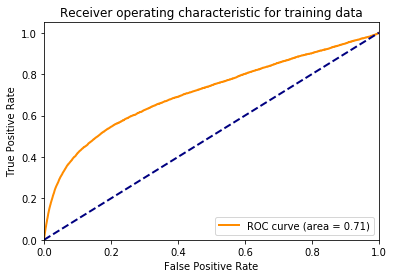

In [66]:
# We will use matplotlib
import matplotlib.pyplot as plt

# Training AUC
plt.figure()
lw = 2
plt.plot(fpr_train, tpr_train, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % train_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for training data')
plt.legend(loc="lower right")
plt.show()

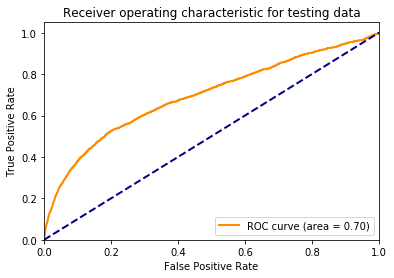

In [67]:

# Testing AUC
plt.figure()
lw = 2
plt.plot(fpr_test, tpr_test, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % test_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for testing data')
plt.legend(loc="lower right")
plt.show()